In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np
import os
from matplotlib import pyplot as plt
from ipywidgets import interact, Dropdown
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

## The below code is getting the season data from 2000 to 2022. This will allow be to build a data model based on trends in touchdowns in the past seasons.

In [3]:
seasons = range(2000, 2023)
df = nfl.import_pbp_data(seasons)

2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


## There is a lot of data in this module so I want to find the columns that relate to a quarterback in the NFL

In [5]:
for column in df.columns:
    # looking for rushing relevant columns
    if 'pass' in column:
        print(column)
    elif 'rec' in column:
        print(column)
    elif 'catch' in column:
        print(column)
    # looking for yard line and distance to endzone relevant columns
    elif 'distance' in column:
        print(column)
    elif 'yardline' in column:
        print(column)
    elif 'td' in column:
        print(column)

yardline_100
pass_length
pass_location
yards_after_catch
kick_distance
td_team
td_player_name
td_player_id
opp_td_prob
td_prob
total_home_pass_epa
total_away_pass_epa
total_home_pass_wpa
total_away_pass_wpa
first_down_pass
incomplete_pass
punt_fair_catch
kickoff_fair_catch
own_kickoff_recovery
own_kickoff_recovery_td
pass_attempt
pass_touchdown
complete_pass
lateral_reception
lateral_recovery
passer_player_id
passer_player_name
passing_yards
receiver_player_id
receiver_player_name
receiving_yards
lateral_receiver_player_id
lateral_receiver_player_name
lateral_receiving_yards
own_kickoff_recovery_player_id
own_kickoff_recovery_player_name
pass_defense_1_player_id
pass_defense_1_player_name
pass_defense_2_player_id
pass_defense_2_player_name
fumble_recovery_1_team
fumble_recovery_1_yards
fumble_recovery_1_player_id
fumble_recovery_1_player_name
fumble_recovery_2_team
fumble_recovery_2_yards
fumble_recovery_2_player_id
fumble_recovery_2_player_name
passer
passer_jersey_number
receiver
rec

## I select the columns relevent to what I want to find and and make my quarterback dataframe

In [6]:
qb_df = df[['pass_attempt', 'pass_touchdown', 'yardline_100', 'two_point_attempt']]

qb_df = qb_df.loc[(qb_df['two_point_attempt'] == 0) & (qb_df['pass_attempt'] == 1)]

qb_df.shape

(445336, 4)

In [7]:
qb_df.sort_values(by = 'yardline_100').head(10)

,pass_attempt,pass_touchdown,yardline_100,two_point_attempt
432374,1.0,0.0,1.0,0.0
736142,1.0,1.0,1.0,0.0
960841,1.0,1.0,1.0,0.0
258361,1.0,1.0,1.0,0.0
258259,1.0,0.0,1.0,0.0
510151,1.0,0.0,1.0,0.0
961133,1.0,1.0,1.0,0.0
961490,1.0,1.0,1.0,0.0
961502,1.0,1.0,1.0,0.0
816878,1.0,0.0,1.0,0.0


## I want to create a column that will show the probability of a passing touchdown based on the distance from the endzone. I suspect that the closer to the endzone the higher probability

In [8]:
qb_prob = qb_df.groupby('yardline_100')['pass_touchdown'].value_counts(normalize = -True)

qb_prob = (
    qb_prob.rename('probability_of_pass_touchdown')
    .reset_index()
    .sort_values('yardline_100')
    .reset_index(drop=True)
)

qb_prob.head()






,yardline_100,pass_touchdown,probability_of_pass_touchdown
0,1.0,1.0,0.506570
1,1.0,0.0,0.493430
2,2.0,0.0,0.545889
3,2.0,1.0,0.454111
4,3.0,0.0,0.588500


## I only want touchdowns scores so I drop the zero values meaning there wasn't a touchdown scored

## The below dataframe shows the probablility of a passing touchdown based on yardline

In [9]:
qb_prob = qb_prob.loc[qb_prob['pass_touchdown'] == 1]

qb_prob = qb_prob.drop('pass_touchdown', axis=1)
qb_prob.head(15)


,yardline_100,probability_of_pass_touchdown
0,1.0,0.506570
3,2.0,0.454111
5,3.0,0.411500
7,4.0,0.365680
9,5.0,0.341273
10,6.0,0.308484
13,7.0,0.273791
15,8.0,0.240472
17,9.0,0.219664
19,10.0,0.198901


<Axes: xlabel='yardline_100'>

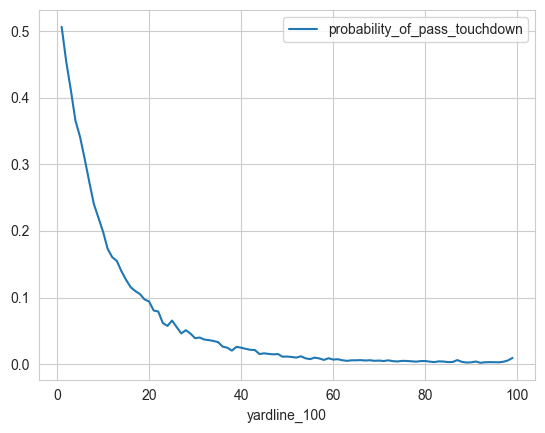

In [10]:
sns.set_style('whitegrid')
qb_prob.plot(x='yardline_100', y='probability_of_pass_touchdown')

## The above plot shows that the probability of a touchdown decreases the further you get from the endzone which is expected

## Now that I have my probability model, I will merge it with the data from the 2022 NFL season

In [11]:
pbp_2022 = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [12]:
pbp_2022 = pbp_2022[['passer_player_name', 'passer_player_id', 'posteam', 'pass_touchdown', 'yardline_100']].dropna()

In [13]:
exp_df = pbp_2022.merge(qb_prob, how='left', on='yardline_100')
exp_df.head()

,passer_player_name,passer_player_id,posteam,pass_touchdown,yardline_100,probability_of_pass_touchdown
0,J.Flacco,00-0026158,NYJ,0.0,59.0,0.008809
1,J.Flacco,00-0026158,NYJ,0.0,54.0,0.008681
2,L.Jackson,00-0034796,BAL,0.0,72.0,0.005677
3,L.Jackson,00-0034796,BAL,0.0,68.0,0.005814
4,L.Jackson,00-0034796,BAL,0.0,60.0,0.006850


## Below I want to calculate the sum of the expected touchdowns and actual touchdowns. I also filter out anyone with less than 5 expected touchdowns because they probably aren't a quarterback but another position that threw for a few touchdowns.

In [14]:

exp_df = exp_df.groupby(['passer_player_name', 'passer_player_id', 'posteam'], as_index=False).agg({
    'probability_of_pass_touchdown': np.sum,
    'pass_touchdown': np.sum
}).rename({'probability_of_pass_touchdown': 'Expected Touchdowns'}, axis=1)

# Filtering players with less than 5 expected touchdowns
exp_df = exp_df[exp_df['Expected Touchdowns'] >= 5]





## Below I change the column names to make them more clear. I also create a new column called Expected Touchdowns Rank and this is just the ranking by who threw for the most expected touchdowns.

In [15]:
exp_df = exp_df.rename(columns={
    "passer_player_name": "Player", 
    "posteam": "Team",
    "passer_player_id":"ID",
    'pass_touchdown': 'Actual Touchdowns'
})

exp_df['Expected Touchdowns Rank'] = exp_df['Expected Touchdowns'].rank(ascending = False)
exp_df.head(15)


,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank
2,A.Dalton,00-0027973,NO,15.444090,18.0,25.0
4,A.Rodgers,00-0023459,GB,27.155585,26.0,10.0
10,B.Mayfield,00-0034855,CAR,6.899688,6.0,38.0
11,B.Mayfield,00-0034855,LA,6.064868,4.0,40.0
13,B.Purdy,00-0037834,SF,11.827054,16.0,32.0
26,C.Rush,00-0033662,DAL,5.659100,5.0,43.0
28,C.Wentz,00-0032950,WAS,13.594231,11.0,30.0
32,D.Carr,00-0031280,LV,21.602842,24.0,12.0
36,D.Jones,00-0035710,NYG,20.770525,17.0,14.0
37,D.Mills,00-0036898,HOU,18.026542,17.0,20.0


## Below I change the column names to make them more clear. I also create a new column called Actual Touchdowns Rank and this is just the ranking by who threw for the most actual touchdowns.

In [16]:
exp_df['Actual Touchdowns Rank'] = exp_df['Actual Touchdowns'].rank(ascending=False)

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank
2,A.Dalton,00-0027973,NO,15.444090,18.0,25.0,15.0
4,A.Rodgers,00-0023459,GB,27.155585,26.0,10.0,10.5
10,B.Mayfield,00-0034855,CAR,6.899688,6.0,38.0,35.5
11,B.Mayfield,00-0034855,LA,6.064868,4.0,40.0,40.5
13,B.Purdy,00-0037834,SF,11.827054,16.0,32.0,21.0


## Below I create a new column called Regression Candidate, this column is the Expected Touchdowns subtracted from the Actual Touchdown. I want to use this to determine who will potentially throw for more touchdowns and who will throw for less touchdowns.

In [17]:
exp_df['Regression Candidate'] = exp_df['Expected Touchdowns'] - exp_df['Actual Touchdowns']

exp_df['Regression Rank Candidate'] = exp_df['Actual Touchdowns Rank'] - exp_df['Expected Touchdowns Rank']

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
2,A.Dalton,00-0027973,NO,15.444090,18.0,25.0,15.0,-2.555910,-10.0
4,A.Rodgers,00-0023459,GB,27.155585,26.0,10.0,10.5,1.155585,0.5
10,B.Mayfield,00-0034855,CAR,6.899688,6.0,38.0,35.5,0.899688,-2.5
11,B.Mayfield,00-0034855,LA,6.064868,4.0,40.0,40.5,2.064868,0.5
13,B.Purdy,00-0037834,SF,11.827054,16.0,32.0,21.0,-4.172946,-11.0


## Looking at the top 15 negative regression Candidates meaning they may score fewer touchdowns this year than they did last year

In [18]:
exp_df.sort_values(by='Regression Candidate').head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
111,T.Tagovailoa,00-0036212,MIA,17.941299,25.0,21.0,12.5,-7.058701,-8.5
38,D.Prescott,00-0033077,DAL,21.132076,28.0,13.0,8.0,-6.867924,-5.0
45,J.Allen,00-0034857,BUF,31.914776,38.0,7.0,3.0,-6.085224,-4.0
43,G.Smith,00-0030565,SEA,27.183510,32.0,9.0,4.0,-4.816490,-5.0
13,B.Purdy,00-0037834,SF,11.827054,16.0,32.0,21.0,-4.172946,-11.0
52,J.Fields,00-0036945,CHI,14.192933,17.0,29.0,17.5,-2.807067,-11.5
2,A.Dalton,00-0027973,NO,15.444090,18.0,25.0,15.0,-2.555910,-10.0
32,D.Carr,00-0031280,LV,21.602842,24.0,12.0,14.0,-2.397158,2.0
59,J.Hurts,00-0036389,PHI,22.781714,25.0,11.0,12.5,-2.218286,1.5
89,P.Mahomes,00-0033873,KC,46.178449,48.0,1.0,1.0,-1.821551,0.0


## Looking at the top 15 positive regression Candidates meaning they may score more touchdowns this year than they did last year

In [19]:
exp_df.sort_values(by='Regression Candidate', ascending=False).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
102,T.Brady,00-0019596,TB,41.399611,27.0,2.0,9.0,14.399611,7.0
58,J.Herbert,00-0036355,LAC,37.665617,26.0,4.0,10.5,11.665617,6.5
70,K.Pickett,00-0038102,PIT,18.199103,7.0,18.0,33.0,11.199103,15.0
78,M.Ryan,00-0026143,IND,20.593600,14.0,15.0,25.0,6.593600,10.0
68,K.Cousins,00-0029604,MIN,37.478345,31.0,5.0,5.0,6.478345,0.0
76,M.Jones,00-0036972,NE,19.870931,14.0,16.0,25.0,5.870931,9.0
79,M.Stafford,00-0026498,LA,15.778401,10.0,24.0,31.0,5.778401,7.0
69,K.Murray,00-0035228,ARI,19.241942,14.0,17.0,25.0,5.241942,8.0
46,J.Brissett,00-0033119,CLE,16.291986,12.0,23.0,28.5,4.291986,5.5
39,D.Ridder,00-0038122,ATL,6.059455,2.0,41.0,45.0,4.059455,4.0


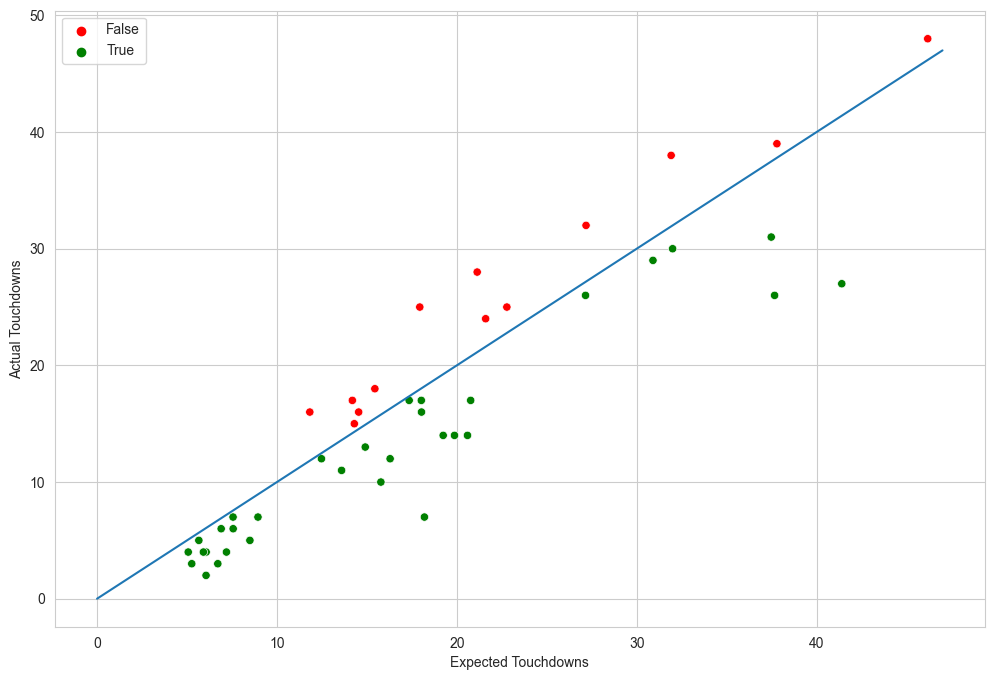

interactive(children=(Dropdown(description='Player:', options=('A.Dalton', 'A.Rodgers', 'B.Mayfield', 'B.Purdy…

<function __main__.select_player(player)>

In [20]:

fig, ax = plt.subplots(figsize=(12, 8))

exp_df['Positive Regression Candidate'] = exp_df['Regression Candidate'] > 0

scatter = sns.scatterplot(
    x='Expected Touchdowns',
    y='Actual Touchdowns',
    hue='Positive Regression Candidate',
    data=exp_df,
    palette=['r', 'g'],
)

max_act_touchdowns = int(exp_df['Actual Touchdowns'].max())
max_exp_touchdowns = int(exp_df['Expected Touchdowns'].max())

max_tds = max(max_act_touchdowns, max_exp_touchdowns)

sns.lineplot(x=range(max_tds), y=range(max_tds))

def select_player(player):
    plt.cla()
    filtered_df = exp_df[exp_df['Player'] == player]
    scatter = sns.scatterplot(
        x='Expected Touchdowns',
        y='Actual Touchdowns',
        hue='Positive Regression Candidate',
        data=filtered_df,
        palette=['r', 'g'],
    )
    sns.lineplot(x=range(max_tds), y=range(max_tds))
    plt.show()

player_dropdown = Dropdown(options=exp_df['Player'].unique(), description='Player:')
interact(select_player, player=player_dropdown)






      


## The visualization shows that if a player is below the blue line they are in line for positive regression meaning potentially more touchdowns and if a player is above the line they are possibly a candidate for fewer touchdowns. This is significant to me because touchdowns are the most important stat when it comes to fantasy football so if you able to identify players who could potentially do better this season and draft them it can give you an advantage.